In [1]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. 


## 📊 Fetching Match Data from API
This script collects detailed football match statistics using the **API-Football** service, a paid data provider offering rich and reliable match data. It targets a specific league and season, retrieving scores, team stats, formations, and other info for analysis or machine learning tasks.

**Configuration**  
- `API_KEY`: Your personal API-Football key  
- `LEAGUE_ID`: League ID (e.g., 307 for Saudi Pro League)  
- `SEASON`: Year (e.g., 2016–2023)

Common `LEAGUE_ID` values:

| League Name      | ID  | Country      |
|------------------|-----|--------------|
| Premier League   | 39  | England      |
| Saudi Pro League | 307 | Saudi Arabia |
| Serie A          | 135 | Italy        |
| Bundesliga       | 78  | Germany      |
| La Liga          | 140 | Spain        |

**Main Steps**  
1. Load all fixtures for the selected league and season  
2. Extract match features:
   - **Goals**: `home_goals`, `away_goals`, half-time goals  
   - **Formations**: `home_formation`, `away_formation`  
   - **Shooting**: `shots_on_target`, `total_shots`  
   - **Possession & Passing**: `ball_possession`, `attempted_passes`, `successful_passes`  
   - **Defense**: `goalkeeper_saves`  
   - **Discipline**: `fouls`, `yellow_cards`, `red_cards`  
   - **Other**: `corner_kicks`, `offsides`  

3. Store all match records in a list  
4. Export the final dataset to a CSV file

**Notes**  
- Adds a delay (`time.sleep(0.3)`) to avoid API rate limits  
- Uses error handling to skip faulty matches  
- Matches without full stats/formations are ignored for quality


In [ ]:
import requests
import pandas as pd
import time

# === API Setup ===
API_KEY = "8746dbdc7482bd04b76b224bf59f1e46"
LEAGUE_ID = 140
SEASON = 2024
HEADERS = {"x-apisports-key": API_KEY}
BASE_URL = "https://v3.football.api-sports.io"

def get_json(endpoint, params):
    url = f"{BASE_URL}/{endpoint}"
    res = requests.get(url, headers=HEADERS, params=params)
    res.raise_for_status()
    return res.json()["response"]

def extract_stat(stats_list, team_name, stat_type):
    for team_stats in stats_list:
        if team_stats["team"]["name"] == team_name:
            for stat in team_stats["statistics"]:
                if stat["type"].lower().replace(" ", "") == stat_type.lower().replace(" ", ""):
                    return stat["value"]
    return None

def get_formations(fixture_id):
    try:
        lineup_data = get_json("fixtures/lineups", {"fixture": fixture_id})
        if len(lineup_data) == 2:
            return lineup_data[0]["formation"], lineup_data[1]["formation"]
    except Exception as e:
        print(f"⚠️ Error fetching formation for fixture {fixture_id}: {e}")
    return None, None

# === Start Processing ===
print(f"🔄 Loading season {SEASON}...")
fixtures = get_json("fixtures", {"league": LEAGUE_ID, "season": SEASON})
print(f"📊 Total fixtures in season {SEASON}: {len(fixtures)}")

rows = []
for fixture in fixtures:
    fixture_id = fixture["fixture"]["id"]
    try:
        fixture_data = get_json("fixtures", {"id": fixture_id})
        if not fixture_data:
            continue

        stats = get_json("fixtures/statistics", {"fixture": fixture_id})
        if not stats or len(stats) < 2:
            continue

        home = fixture["teams"]["home"]["name"]
        away = fixture["teams"]["away"]["name"]
        fixture = fixture_data[0]

        home_form, away_form = get_formations(fixture_id)

        row = {
            "fixture_id": fixture_id,
            "league": fixture["league"]["name"],
            "season": fixture["league"]["season"],
            "date": fixture["fixture"]["date"],
            "stadium": fixture["fixture"]["venue"]["name"],
            "game_week": fixture["league"]["round"],
            "home_team": home,
            "away_team": away,
            "home_goals": fixture["goals"]["home"],
            "away_goals": fixture["goals"]["away"],
            "ht_home_goals": fixture["score"]["halftime"]["home"],
            "ht_away_goals": fixture["score"]["halftime"]["away"],
            "home_formation": home_form,
            "away_formation": away_form,
            "home_shots_on_target": extract_stat(stats, home, "Shots on Goal"),
            "home_shots": extract_stat(stats, home, "Total Shots"),
            "home_fouls": extract_stat(stats, home, "Fouls"),
            "home_corners": extract_stat(stats, home, "Corner Kicks"),
            "home_offsides": extract_stat(stats, home, "Offsides"),
            "home_possession": extract_stat(stats, home, "Ball Possession"),
            "home_yellow_cards": extract_stat(stats, home, "Yellow Cards"),
            "home_red_cards": extract_stat(stats, home, "Red Cards"),
            "home_goalkeeper_saves": extract_stat(stats, home, "Goalkeeper Saves"),
            "home_attempted_passes": extract_stat(stats, home, "Total passes"),
            "home_successful_passes": extract_stat(stats, home, "Passes accurate"),
            "away_shots_on_target": extract_stat(stats, away, "Shots on Goal"),
            "away_shots": extract_stat(stats, away, "Total Shots"),
            "away_fouls": extract_stat(stats, away, "Fouls"),
            "away_corners": extract_stat(stats, away, "Corner Kicks"),
            "away_offsides": extract_stat(stats, away, "Offsides"),
            "away_possession": extract_stat(stats, away, "Ball Possession"),
            "away_yellow_cards": extract_stat(stats, away, "Yellow Cards"),
            "away_red_cards": extract_stat(stats, away, "Red Cards"),
            "away_goalkeeper_saves": extract_stat(stats, away, "Goalkeeper Saves"),
            "away_attempted_passes": extract_stat(stats, away, "Total passes"),
            "away_successful_passes": extract_stat(stats, away, "Passes accurate"),
        }

        rows.append(row)
        print(f"✅ Saved fixture {fixture_id} ({len(rows)})")
        time.sleep(0.1)
    except Exception as e:
        print(f"❌ Error in fixture {fixture_id}: {e}")

# Save to CSV
df = pd.DataFrame(rows)
file_name = f"season_{LEAGUE_ID}_{SEASON}.csv"
df.to_csv(file_name, index=False, encoding='utf-8-sig')
print(f"🎉 Data saved to {file_name}")


📊 Combine Match Data from 2016–2023 into a Single CSV



In [ ]:
import pandas as pd

file_paths = [
    "/content/season_307_2023.csv",
    "/content/season_307_2022.csv",
    "/content/season_307_2021.csv",
    "/content/season_307_2020.csv",
    "/content/season_307_2019.csv",
    "/content/season_307_2018.csv",
    "/content/season_307_2017.csv",
    "/content/season_307_2016.csv"
]

dfs = [pd.read_csv(file) for file in file_paths]
merged_df = pd.concat(dfs, ignore_index=True)

merged_df.to_csv("L_S_2023_2016.csv", index=False)


🔄 Merge All League Files into one CSV




In [ ]:
import pandas as pd

file_paths = [
    "/content/L_P_2023_2016.csv",
    "/content/L_SP_2023_2016.csv",
    "/content/L_S_2023_2016.csv",
    "/content/L_G_2023_2016.csv",
    "/content/L_I_2023_2016.csv"
]

dfs = [pd.read_csv(file) for file in file_paths]
merged_df = pd.concat(dfs, ignore_index=True)

merged_df.to_csv("all_2023_2016.csv", index=False)


## ⚙️ Match Data Preparation and Feature Engineering  
This notebook prepares football match data for machine learning by cleaning missing values, encoding categorical variables, generating the match result, and creating recent team form features (based on the last 5 games).  
The final dataset becomes ready for training predictive models.


Step 1: Load & Enrich Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor
import joblib

Load dataset that includes team rank & points

In [2]:
df = pd.read_csv("/content/all_data_with_rank_and_point.csv")

 Manually calculate rank and points differences\
 These are new features that compare team vs opponent\
 For example: home_rank_dif = home_rank - away_rank

In [3]:
df['home_rank_dif'] = df['home_rank'] - df['away_rank']
df['away_rank_dif'] = -df['home_rank_dif']
df['home_points_dif'] = df['home_points'] - df['away_points']
df['away_points_dif'] = -df['home_points_dif']


Step 2: Convert to Team-Level Format

In [4]:
def convert_to_team_level(df):
    shared_cols = ['fixture_id', 'league', 'season', 'date', 'stadium', 'game_week']
    team_cols = {
        'home_team': 'team', 'away_team': 'opponent',
        'home_goals': 'team_goals', 'away_goals': 'opponent_goals',
        'home_shots_on_target': 'team_shots_on_target', 'away_shots_on_target': 'opponent_shots_on_target',
        'home_shots': 'team_shots', 'away_shots': 'opponent_shots',
        'home_fouls': 'team_fouls', 'away_fouls': 'opponent_fouls',
        'home_corners': 'team_corners', 'away_corners': 'opponent_corners',
        'home_offsides': 'team_offsides', 'away_offsides': 'opponent_offsides',
        'home_possession': 'team_possession', 'away_possession': 'opponent_possession',
        'home_yellow_cards': 'team_yellow_cards', 'away_yellow_cards': 'opponent_yellow_cards',
        'home_red_cards': 'team_red_cards', 'away_red_cards': 'opponent_red_cards',
        'home_goalkeeper_saves': 'team_saves', 'away_goalkeeper_saves': 'opponent_saves',
        'home_attempted_passes': 'team_attempted_passes', 'away_attempted_passes': 'opponent_attempted_passes',
        'home_successful_passes': 'team_successful_passes', 'away_successful_passes': 'opponent_successful_passes',
        'home_formation': 'team_formation', 'away_formation': 'opponent_formation',
        'home_rank': 'team_rank', 'away_rank': 'opponent_rank',
        'home_points': 'team_points', 'away_points': 'opponent_points',
        'home_rank_dif': 'team_rank_dif', 'away_rank_dif': 'opponent_rank_dif',
        'home_points_dif': 'team_points_dif', 'away_points_dif': 'opponent_points_dif',
    }

    df_home = df[shared_cols + list(team_cols.keys())].copy()
    df_home.rename(columns=team_cols, inplace=True)
    df_home['is_home'] = 1
    df_home['team_win'] = (df_home['team_goals'] > df_home['opponent_goals']).astype(int)

    swapped_cols = {
        'away_team': 'team', 'home_team': 'opponent',
        'away_goals': 'team_goals', 'home_goals': 'opponent_goals',
        'away_shots_on_target': 'team_shots_on_target', 'home_shots_on_target': 'opponent_shots_on_target',
        'away_shots': 'team_shots', 'home_shots': 'opponent_shots',
        'away_fouls': 'team_fouls', 'home_fouls': 'opponent_fouls',
        'away_corners': 'team_corners', 'home_corners': 'opponent_corners',
        'away_offsides': 'team_offsides', 'home_offsides': 'opponent_offsides',
        'away_possession': 'team_possession', 'home_possession': 'opponent_possession',
        'away_yellow_cards': 'team_yellow_cards', 'home_yellow_cards': 'opponent_yellow_cards',
        'away_red_cards': 'team_red_cards', 'home_red_cards': 'opponent_red_cards',
        'away_goalkeeper_saves': 'team_saves', 'home_goalkeeper_saves': 'opponent_saves',
        'away_attempted_passes': 'team_attempted_passes', 'home_attempted_passes': 'opponent_attempted_passes',
        'away_successful_passes': 'team_successful_passes', 'home_successful_passes': 'opponent_successful_passes',
        'away_formation': 'team_formation', 'home_formation': 'opponent_formation',
        'away_rank': 'team_rank', 'home_rank': 'opponent_rank',
        'away_points': 'team_points', 'home_points': 'opponent_points',
        'away_rank_dif': 'team_rank_dif', 'home_rank_dif': 'opponent_rank_dif',
        'away_points_dif': 'team_points_dif', 'home_points_dif': 'opponent_points_dif',
    }

    df_away = df[shared_cols + list(swapped_cols.keys())].copy()
    df_away.rename(columns=swapped_cols, inplace=True)
    df_away['is_home'] = 0
    df_away['team_win'] = (df_away['team_goals'] > df_away['opponent_goals']).astype(int)

    return pd.concat([df_home, df_away], ignore_index=True)

df_team = convert_to_team_level(df)

Step 3: Clean & Process Columns

In [5]:
zero_fill_cols = [
    'team_red_cards', 'team_yellow_cards', 'team_saves',
    'opponent_red_cards', 'opponent_yellow_cards', 'opponent_saves',
    'team_offsides', 'opponent_offsides',
    'team_attempted_passes', 'opponent_attempted_passes'
]
for col in zero_fill_cols:
    df_team[col] = df_team[col].fillna(0)

for col in ['team_possession', 'opponent_possession']:
    df_team[col] = df_team[col].astype(str).str.replace('%', '', regex=False).astype(float)


 Calculate pass accuracy as new feature\
Then drop successful_passes columns

In [6]:
df_team['team_pass_accuracy'] = (df_team['team_successful_passes'] / df_team['team_attempted_passes']).fillna(0)
df_team['opponent_pass_accuracy'] = (df_team['opponent_successful_passes'] / df_team['opponent_attempted_passes']).fillna(0)
df_team.drop(columns=['team_successful_passes', 'opponent_successful_passes'], inplace=True)


Step 4: Encode Categorical

In [7]:
le_team = LabelEncoder()
le_opp = LabelEncoder()
le_form_team = LabelEncoder()
le_form_opp = LabelEncoder()
df_team['team'] = le_team.fit_transform(df_team['team'])
df_team['opponent'] = le_opp.fit_transform(df_team['opponent'])
df_team['team_formation'] = le_form_team.fit_transform(df_team['team_formation'])
df_team['opponent_formation'] = le_form_opp.fit_transform(df_team['opponent_formation'])


Step 5: Formation Win Rate Feature

In [8]:
team_form_win_rate = df_team.groupby('team_formation')['team_win'].mean().to_dict()
opp_form_win_rate = df_team.groupby('opponent_formation')['team_win'].apply(lambda x: 1 - x.mean()).to_dict()
df_team['team_form_win_rate'] = df_team['team_formation'].map(team_form_win_rate)
df_team['opponent_form_win_rate'] = df_team['opponent_formation'].map(opp_form_win_rate)


Step 6: Compute Recent Wins/Draws/Losses

In [9]:
def get_recent_form_team_level(df, team_id, current_index, n_matches=5):
    team_matches = df.loc[:current_index-1]
    team_data = team_matches[(team_matches['team'] == team_id)].tail(n_matches)
    wins = (team_data['team_win'] == 1).sum()
    draws = (team_data['team_win'] == 0.5).sum()
    losses = (team_data['team_win'] == 0).sum()
    return wins, draws, losses

recent_wins, recent_draws, recent_losses = [], [], []
for idx, row in df_team.iterrows():
    w, d, l = get_recent_form_team_level(df_team, row['team'], idx)
    recent_wins.append(w)
    recent_draws.append(d)
    recent_losses.append(l)

df_team['recent_wins'] = recent_wins
df_team['recent_draws'] = recent_draws
df_team['recent_losses'] = recent_losses

Remove any known broken rows

In [10]:
df_team = df_team[df_team["fixture_id"] != 1208324]

Step 7: Final Features + Target

In [11]:
df_team.loc[:, 'team_win'] = np.where(
    df_team['team_goals'] > df_team['opponent_goals'], 1,
    np.where(df_team['team_goals'] == df_team['opponent_goals'], 0.5, 0)
)



features = [
    'season', 'league', 'game_week', 'team', 'opponent', 'is_home',
    'team_formation', 'team_form_win_rate',
    'opponent_formation', 'opponent_form_win_rate',
    'team_shots_on_target', 'team_shots', 'team_fouls', 'team_corners',
    'team_offsides', 'team_possession', 'team_yellow_cards', 'team_red_cards',
    'team_saves', 'team_pass_accuracy',
    'opponent_shots_on_target', 'opponent_shots', 'opponent_fouls', 'opponent_corners',
    'opponent_offsides', 'opponent_possession', 'opponent_yellow_cards', 'opponent_red_cards',
    'opponent_saves', 'opponent_pass_accuracy',
    'recent_wins', 'recent_draws', 'recent_losses',
    'team_rank', 'opponent_rank',
    'team_points', 'opponent_points',
    'team_rank_dif', 'opponent_rank_dif',
    'team_points_dif', 'opponent_points_dif'
]

numeric_features = [
    'team_shots_on_target', 'team_shots', 'team_fouls', 'team_corners',
    'team_offsides', 'team_possession', 'team_yellow_cards', 'team_red_cards',
    'team_saves', 'team_pass_accuracy',
    'opponent_shots_on_target', 'opponent_shots', 'opponent_fouls', 'opponent_corners',
    'opponent_offsides', 'opponent_possession', 'opponent_yellow_cards', 'opponent_red_cards',
    'opponent_saves', 'opponent_pass_accuracy',
    'recent_wins', 'recent_draws', 'recent_losses',
    'team_rank', 'opponent_rank',
    'team_points', 'opponent_points',
    'team_rank_dif', 'opponent_rank_dif',
    'team_points_dif', 'opponent_points_dif'
]



<ipython-input-11-4ab54130340d>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.  1.  0.5 ... 1.  1.  0.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_team.loc[:, 'team_win'] = np.where(


Step 8: Normalize Numeric Features

In [12]:
df_scaled = df_team.copy()
scaler = StandardScaler()
df_scaled[numeric_features] = scaler.fit_transform(df_scaled[numeric_features])


Step 9: Save Encoders

In [13]:
joblib.dump(le_team, "le_team.pkl")
joblib.dump(le_opp, "le_opp.pkl")
joblib.dump(le_form_team, "le_form_team.pkl")
joblib.dump(le_form_opp, "le_form_opp.pkl")
joblib.dump(scaler, "scaler.pkl")



['scaler.pkl']

Step 10: Train AutoGluon Model

In [14]:
df_final = df_scaled[features + ['team_win']].dropna()
train_data, test_data = train_test_split(df_final, test_size=0.2, random_state=42)

In [15]:
predictor = TabularPredictor(label='team_win', problem_type='multiclass', eval_metric='log_loss')
predictor.fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20250410_063254"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       11.17 GB / 12.67 GB (88.1%)
Disk Space Avail:   62.27 GB / 107.72 GB (57.8%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions 

[1000]	valid_set's multi_logloss: 0.464656
[2000]	valid_set's multi_logloss: 0.440249


	-0.44	 = Validation score   (-log_loss)
	52.7s	 = Training   runtime
	2.51s	 = Validation runtime
Fitting model: LightGBM ...
	-0.3853	 = Validation score   (-log_loss)
	16.67s	 = Training   runtime
	0.65s	 = Validation runtime
Fitting model: RandomForestGini ...
	-0.7475	 = Validation score   (-log_loss)
	18.87s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: RandomForestEntr ...
	-0.7392	 = Validation score   (-log_loss)
	22.77s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: CatBoost ...
	-0.3785	 = Validation score   (-log_loss)
	376.1s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	-0.7917	 = Validation score   (-log_loss)
	10.44s	 = Training   runtime
	0.25s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	-0.7877	 = Validation score   (-log_loss)
	16.46s	 = Training   runtime
	0.48s	 = Validation runtime
Fitting model: XGBoost ...
	-0.3785	 = Validation score   (-log_loss)
	22.97s	 = Training   r

In [16]:
predictor.feature_importance(df_final)

These features in provided data are not utilized by the predictor and will be ignored: ['recent_draws']
Computing feature importance via permutation shuffling for 40 features using 5000 rows with 5 shuffle sets...
/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
	422.89s	= Expected runtime (84.58s per shuffle set)
/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when load

,importance,stddev,p_value,n,p99_high,p99_low
opponent_shots_on_target,2.371898,0.039461,9.189649e-09,5,2.453148,2.290648
team_shots_on_target,2.333905,0.015969,2.629663e-10,5,2.366785,2.301026
opponent_saves,1.350857,0.033802,4.700805e-08,5,1.420456,1.281257
team_saves,1.340692,0.034177,5.063025e-08,5,1.411062,1.270321
game_week,0.029602,0.001390,5.816026e-07,5,0.032464,0.026740
team_possession,0.023820,0.003137,3.527643e-05,5,0.030279,0.017361
team_points_dif,0.015896,0.000768,6.529985e-07,5,0.017478,0.014314
opponent_possession,0.014389,0.002352,8.274279e-05,5,0.019232,0.009545
team_points,0.011554,0.001559,3.880859e-05,5,0.014764,0.008345
is_home,0.011279,0.001084,1.010793e-05,5,0.013510,0.009047


In [17]:
predictor.leaderboard(test_data, silent=True)


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.332254,-0.327659,log_loss,2.520870,0.914036,484.885791,0.009125,0.002499,0.556630,2,True,14
1,NeuralNetFastAI,-0.350850,-0.351571,log_loss,0.123294,0.057144,34.564114,0.123294,0.057144,34.564114,1,True,3
2,NeuralNetTorch,-0.351396,-0.342709,log_loss,0.053008,0.032476,47.745315,0.053008,0.032476,47.745315,1,True,12
3,XGBoost,-0.379570,-0.378485,log_loss,0.761752,0.256547,22.966853,0.761752,0.256547,22.966853,1,True,11
4,LightGBM,-0.381799,-0.385287,log_loss,1.453722,0.647141,16.670252,1.453722,0.647141,16.670252,1,True,5
5,CatBoost,-0.383383,-0.378531,log_loss,0.201309,0.056066,376.099791,0.201309,0.056066,376.099791,1,True,8
6,LightGBMLarge,-0.388252,-0.384627,log_loss,2.134135,0.765851,25.919940,2.134135,0.765851,25.919940,1,True,13
7,LightGBMXT,-0.442601,-0.439994,log_loss,7.502192,2.505572,52.703498,7.502192,2.505572,52.703498,1,True,4
8,RandomForestEntr,-0.740734,-0.739180,log_loss,0.971047,0.231215,22.766433,0.971047,0.231215,22.766433,1,True,7
9,RandomForestGini,-0.747854,-0.747506,log_loss,1.111237,0.242558,18.867321,1.111237,0.242558,18.867321,1,True,6


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


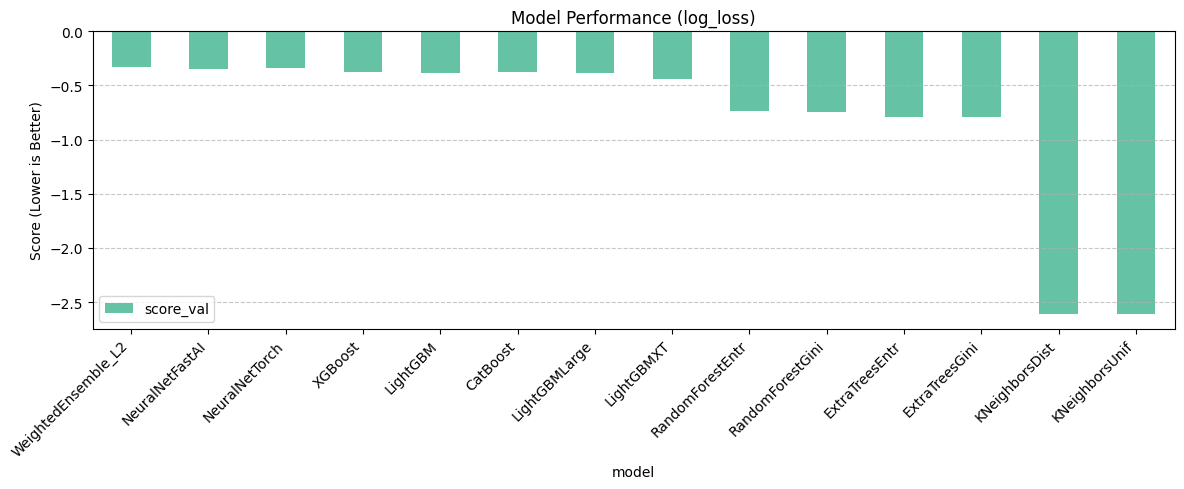

In [38]:
leaderboard_df = predictor.leaderboard(test_data, silent=True)

metrics_df = leaderboard_df[['model', 'score_val']].copy()
metrics_df.set_index('model', inplace=True)

metrics_df.plot(kind='bar', figsize=(12, 5), colormap='Set2')
plt.title('Model Performance (log_loss)')
plt.ylabel('Score (Lower is Better)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




### 📌 **Live Match Outcome Prediction Every 5 Minutes**
In this section, we load live match snapshots captured every 5 minutes, including team stats, formations, and current performance. Using a pre-trained model, we predict the win/draw/loss probabilities for each team in real-time.  
The data includes updated metrics such as team rankings, points, passing accuracy, and recent form. These features are scaled and passed into the model to provide tactical insights during the match.



Step 1: Load Data and Add Manual Ranks & Points

In [20]:
import pandas as pd
import numpy as np
import joblib
from autogluon.tabular import TabularPredictor

df_snapshot = pd.read_csv("/content/Match_Data_with_Kickoff.csv")
df_all = pd.read_csv("/content/all_data_with_rank_and_point.csv")


team_info = {
    'Chelsea': {'rank': 4, 'points': 53},
    'Other Team': {'rank': 12, 'points': 42}
}

def get_team_rank(team):
    return team_info.get(team, {}).get('rank', np.nan)

def get_team_points(team):
    return team_info.get(team, {}).get('points', np.nan)


df_snapshot['home_rank'] = df_snapshot['home_team'].apply(get_team_rank)
df_snapshot['away_rank'] = df_snapshot['away_team'].apply(get_team_rank)
df_snapshot['home_points'] = df_snapshot['home_team'].apply(get_team_points)
df_snapshot['away_points'] = df_snapshot['away_team'].apply(get_team_points)

Step 2: Add Difference Columns

In [21]:
for df in [df_snapshot, df_all]:
    df['home_rank_dif'] = df['home_rank'] - df['away_rank']
    df['away_rank_dif'] = -df['home_rank_dif']
    df['home_points_dif'] = df['home_points'] - df['away_points']
    df['away_points_dif'] = -df['home_points_dif']


Step 3: Convert to Team-Level Format

In [22]:
def convert_to_team_level(df):
    shared_cols = ['fixture_id', 'league', 'season', 'date', 'stadium', 'game_week']
    if 'timestamp' in df.columns:
        shared_cols.append('timestamp')
    team_cols = {
        'home_team': 'team', 'away_team': 'opponent',
        'home_goals': 'team_goals', 'away_goals': 'opponent_goals',
        'home_shots_on_target': 'team_shots_on_target', 'away_shots_on_target': 'opponent_shots_on_target',
        'home_shots': 'team_shots', 'away_shots': 'opponent_shots',
        'home_fouls': 'team_fouls', 'away_fouls': 'opponent_fouls',
        'home_corners': 'team_corners', 'away_corners': 'opponent_corners',
        'home_offsides': 'team_offsides', 'away_offsides': 'opponent_offsides',
        'home_possession': 'team_possession', 'away_possession': 'opponent_possession',
        'home_yellow_cards': 'team_yellow_cards', 'away_yellow_cards': 'opponent_yellow_cards',
        'home_red_cards': 'team_red_cards', 'away_red_cards': 'opponent_red_cards',
        'home_goalkeeper_saves': 'team_saves', 'away_goalkeeper_saves': 'opponent_saves',
        'home_attempted_passes': 'team_attempted_passes', 'away_attempted_passes': 'opponent_attempted_passes',
        'home_successful_passes': 'team_successful_passes', 'away_successful_passes': 'opponent_successful_passes',
        'home_formation': 'team_formation', 'away_formation': 'opponent_formation',
        'home_rank': 'team_rank', 'away_rank': 'opponent_rank',
        'home_points': 'team_points', 'away_points': 'opponent_points',
        'home_rank_dif': 'team_rank_dif', 'away_rank_dif': 'opponent_rank_dif',
        'home_points_dif': 'team_points_dif', 'away_points_dif': 'opponent_points_dif',
    }

    df_home = df[shared_cols + list(team_cols.keys())].copy()
    df_home.rename(columns=team_cols, inplace=True)
    df_home['is_home'] = 1

    df_away = df[shared_cols + list(team_cols.keys())].copy()
    swap = {k: v for k, v in team_cols.items()}
    swap = {k.replace("home", "away") if "home" in k else k.replace("away", "home"): v for k, v in swap.items()}
    df_away.rename(columns=swap, inplace=True)
    df_away['is_home'] = 0

    return pd.concat([df_home, df_away], ignore_index=True)


df_team = convert_to_team_level(df_snapshot)
df_team['timestamp'] = pd.concat([df_snapshot['timestamp'], df_snapshot['timestamp']]).reset_index(drop=True)


Step 4: Clean & Format Columns

In [23]:
zero_fill_cols = ['team_red_cards', 'team_yellow_cards', 'team_saves',
    'opponent_red_cards', 'opponent_yellow_cards', 'opponent_saves',
    'team_offsides', 'opponent_offsides',
    'team_attempted_passes', 'opponent_attempted_passes']
for col in zero_fill_cols:
    df_team[col] = df_team[col].fillna(0)

for col in ['team_possession', 'opponent_possession']:
    df_team[col] = df_team[col].astype(str).str.replace('%', '', regex=False).astype(float)

df_team['team_pass_accuracy'] = (df_team['team_successful_passes'] / df_team['team_attempted_passes']).fillna(0)
df_team['opponent_pass_accuracy'] = (df_team['opponent_successful_passes'] / df_team['opponent_attempted_passes']).fillna(0)
df_team.drop(columns=['team_successful_passes', 'opponent_successful_passes'], inplace=True)

Step 5: Encode Team and Formation

In [24]:
le_team = joblib.load("/content/le_team.pkl")
le_opp = joblib.load("/content/le_opp.pkl")
le_form_team = joblib.load("/content/le_form_team.pkl")
le_form_opp = joblib.load("/content/le_form_opp.pkl")

df_team['team'] = le_team.transform(df_team['team'])
df_team['opponent'] = le_opp.transform(df_team['opponent'])
df_team['team_formation'] = le_form_team.transform(df_team['team_formation'])
df_team['opponent_formation'] = le_form_opp.transform(df_team['opponent_formation'])


Step 6: Add Form Win Rates

In [25]:
df_all_team = convert_to_team_level(df_all)
df_all_team['team_win'] = (df_all_team['team_goals'] > df_all_team['opponent_goals']).astype(int)

team_form_win_rate = df_all_team.groupby('team_formation')['team_win'].mean().to_dict()
opp_form_win_rate = df_all_team.groupby('opponent_formation')['team_win'].apply(lambda x: 1 - x.mean()).to_dict()

df_team['team_form_win_rate'] = df_team['team_formation'].map(team_form_win_rate).fillna(0.5)
df_team['opponent_form_win_rate'] = df_team['opponent_formation'].map(opp_form_win_rate).fillna(0.5)

Step 7: Add Recent Form

In [26]:
def get_recent_form_team_level(df, team_id, game_index, n_matches=5):
    past_games = df[(df['team'] == team_id) & (df.index < game_index)]
    recent = past_games.tail(n_matches)
    wins = recent['team_win'].eq(1).sum()
    draws = recent['team_win'].eq(0.5).sum()
    losses = recent['team_win'].eq(0).sum()
    return wins, draws, losses

recent_wins, recent_draws, recent_losses = [], [], []
for idx, row in df_team.iterrows():
    team_id = row['team']
    w, d, l = get_recent_form_team_level(df_all_team, team_id, df_all_team.shape[0])
    recent_wins.append(w)
    recent_draws.append(d)
    recent_losses.append(l)

df_team['recent_wins'] = recent_wins
df_team['recent_draws'] = recent_draws
df_team['recent_losses'] = recent_losses

In [27]:
features = [
    'season', 'league', 'game_week', 'team', 'opponent', 'is_home',
    'team_formation', 'team_form_win_rate',
    'opponent_formation', 'opponent_form_win_rate',
    'team_shots_on_target', 'team_shots', 'team_fouls', 'team_corners',
    'team_offsides', 'team_possession', 'team_yellow_cards', 'team_red_cards',
    'team_saves', 'team_pass_accuracy',
    'opponent_shots_on_target', 'opponent_shots', 'opponent_fouls', 'opponent_corners',
    'opponent_offsides', 'opponent_possession', 'opponent_yellow_cards', 'opponent_red_cards',
    'opponent_saves', 'opponent_pass_accuracy',
    'recent_wins', 'recent_draws', 'recent_losses',
    'team_rank', 'opponent_rank',
    'team_points', 'opponent_points',
    'team_rank_dif', 'opponent_rank_dif',
    'team_points_dif', 'opponent_points_dif'
]

scaler = joblib.load("/content/scaler.pkl")
scale_cols = list(scaler.feature_names_in_)

df_team[scale_cols] = pd.DataFrame(
    scaler.transform(df_team[scale_cols]),
    columns=scale_cols,
    index=df_team.index
)



 Step 8 & 9: Predict with Trained Model

In [29]:
predictor = TabularPredictor.load("/content/AutogluonModels/ag-20250410_063254")
preds = predictor.predict_proba(df_team[features])

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


Step 10: Display Predictions

In [30]:

df_team = df_team.sort_values(["timestamp", "team"]).reset_index(drop=True)

for i in range(0, len(df_team), 2):
    row1 = df_team.iloc[i]
    row2 = df_team.iloc[i + 1]
    probs1 = preds.iloc[i]
    probs2 = preds.iloc[i + 1]

    team1 = le_team.inverse_transform([row1['team']])[0]
    team2 = le_team.inverse_transform([row2['team']])[0]
    timestamp = row1['timestamp']

    print(f"⏱️ {timestamp}")
    print(f"🏟️ {team1} → Win: {probs1.get(1.0, 0):.2%}, Draw: {probs1.get(0.5, 0):.2%}, Loss: {probs1.get(0.0, 0):.2%}")
    print(f"🏟️ {team2} → Win: {probs2.get(1.0, 0):.2%}, Draw: {probs2.get(0.5, 0):.2%}, Loss: {probs2.get(0.0, 0):.2%}")
    print("-" * 50)


⏱️ 2025-04-06 13:45:41
🏟️ Brentford → Win: 11.19%, Draw: 87.40%, Loss: 1.42%
🏟️ Chelsea → Win: 14.21%, Draw: 82.69%, Loss: 3.10%
--------------------------------------------------
⏱️ 2025-04-06 13:46:41
🏟️ Brentford → Win: 14.15%, Draw: 82.85%, Loss: 3.00%
🏟️ Chelsea → Win: 14.21%, Draw: 82.69%, Loss: 3.10%
--------------------------------------------------
⏱️ 2025-04-06 13:51:41
🏟️ Brentford → Win: 14.21%, Draw: 82.69%, Loss: 3.10%
🏟️ Chelsea → Win: 14.15%, Draw: 82.85%, Loss: 3.00%
--------------------------------------------------
⏱️ 2025-04-06 13:56:42
🏟️ Brentford → Win: 12.27%, Draw: 84.78%, Loss: 2.94%
🏟️ Chelsea → Win: 14.55%, Draw: 82.56%, Loss: 2.88%
--------------------------------------------------
⏱️ 2025-04-06 14:01:42
🏟️ Brentford → Win: 75.31%, Draw: 24.48%, Loss: 0.21%
🏟️ Chelsea → Win: 75.19%, Draw: 24.64%, Loss: 0.17%
--------------------------------------------------
⏱️ 2025-04-06 14:06:43
🏟️ Brentford → Win: 67.60%, Draw: 31.85%, Loss: 0.56%
🏟️ Chelsea → Win: 68.75

In [95]:
df_team = df_team.sort_values(["timestamp", "team"]).reset_index(drop=True)

def generate_recommendation(prob_win, prob_draw, prob_loss):
    if prob_win > 0.5:
        return "✅ التوصية: استمر على نفس التشكيلة، الوضع ممتاز!"
    elif prob_draw > 0.4 and prob_win < 0.3:
        return "⚠️ التوصية: الفريق بحاجة لهجوم أكثر، فكّر بتبديل هجومي."
    elif prob_loss > 0.5:
        return "❌ التوصية: الوضع سيء، غيّر التشكيلة أو ركّز على الدفاع."
    else:
        return "🔄 التوصية: المباراة متوازنة، حافظ على الكرة واستغل الفرص."


for i in range(0, len(df_team), 2):
    row1 = df_team.iloc[i]
    row2 = df_team.iloc[i + 1]
    probs1 = preds.iloc[i]
    probs2 = preds.iloc[i + 1]

    team1 = le_team.inverse_transform([row1['team']])[0].strip()
    team2 = le_team.inverse_transform([row2['team']])[0].strip()
    timestamp = row1['timestamp']

    team_probs = {
        team1: probs1,
        team2: probs2
    }

    print(f"⏱️ {timestamp}")

    # ترتيب ثابت: برينتفورد ثم تشيلسي
    for team_name in ['Brentford', 'Chelsea']:
        probs = team_probs.get(team_name, pd.Series({1.0: 0, 0.5: 0, 0.0: 0}))
        win = probs.get(1.0, 0)
        draw = probs.get(0.5, 0)
        loss = probs.get(0.0, 0)
        print(f"🏟️ {team_name} → Win: {win:.2%}, Draw: {draw:.2%}, Loss: {loss:.2%}")

        if team_name == "Chelsea":
            print(generate_recommendation(win, draw, loss))

    print("-" * 50)


⏱️ 2025-04-06 13:45:41
🏟️ Brentford → Win: 11.19%, Draw: 87.40%, Loss: 1.42%
🏟️ Chelsea → Win: 14.21%, Draw: 82.69%, Loss: 3.10%
⚠️ التوصية: الفريق بحاجة لهجوم أكثر، فكّر بتبديل هجومي.
--------------------------------------------------
⏱️ 2025-04-06 13:46:41
🏟️ Brentford → Win: 14.15%, Draw: 82.85%, Loss: 3.00%
🏟️ Chelsea → Win: 14.21%, Draw: 82.69%, Loss: 3.10%
⚠️ التوصية: الفريق بحاجة لهجوم أكثر، فكّر بتبديل هجومي.
--------------------------------------------------
⏱️ 2025-04-06 13:51:41
🏟️ Brentford → Win: 14.21%, Draw: 82.69%, Loss: 3.10%
🏟️ Chelsea → Win: 14.15%, Draw: 82.85%, Loss: 3.00%
⚠️ التوصية: الفريق بحاجة لهجوم أكثر، فكّر بتبديل هجومي.
--------------------------------------------------
⏱️ 2025-04-06 13:56:42
🏟️ Brentford → Win: 12.27%, Draw: 84.78%, Loss: 2.94%
🏟️ Chelsea → Win: 14.55%, Draw: 82.56%, Loss: 2.88%
⚠️ التوصية: الفريق بحاجة لهجوم أكثر، فكّر بتبديل هجومي.
--------------------------------------------------
⏱️ 2025-04-06 14:01:42
🏟️ Brentford → Win: 75.31%, Draw:

In [34]:
curve_data = []

df_team = df_team.sort_values(["timestamp", "team"]).reset_index(drop=True)

for i in range(0, len(df_team), 2):
    row1 = df_team.iloc[i]
    row2 = df_team.iloc[i + 1]
    probs1 = preds.iloc[i]
    probs2 = preds.iloc[i + 1]

    team1 = le_team.inverse_transform([row1['team']])[0]
    team2 = le_team.inverse_transform([row2['team']])[0]
    timestamp = row1['timestamp']

    curve_data.append({'timestamp': timestamp, 'team': team1, 'Win': probs1.get(1.0, 0), 'Draw': probs1.get(0.5, 0), 'Loss': probs1.get(0.0, 0)})
    curve_data.append({'timestamp': timestamp, 'team': team2, 'Win': probs2.get(1.0, 0), 'Draw': probs2.get(0.5, 0), 'Loss': probs2.get(0.0, 0)})

df_curve = pd.DataFrame(curve_data)


<ipython-input-35-e083d5ce98cc>:17: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-35-e083d5ce98cc>:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


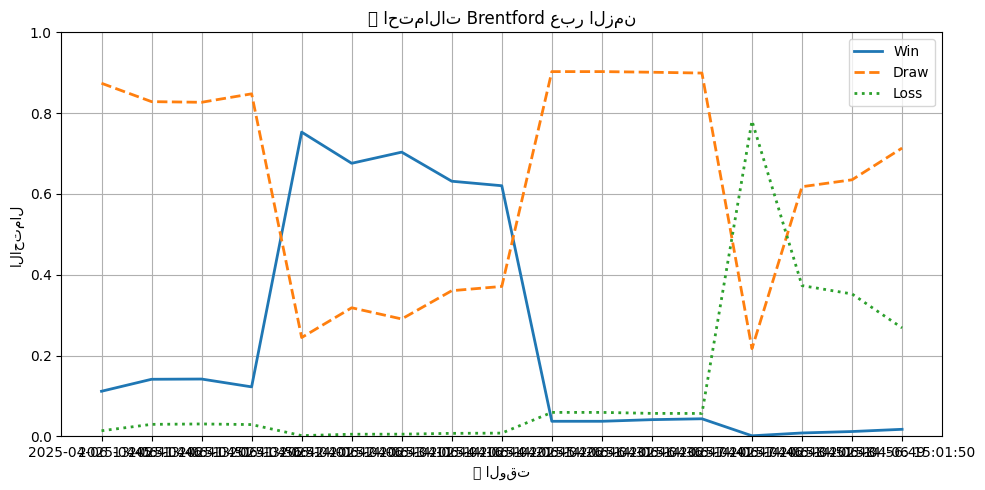

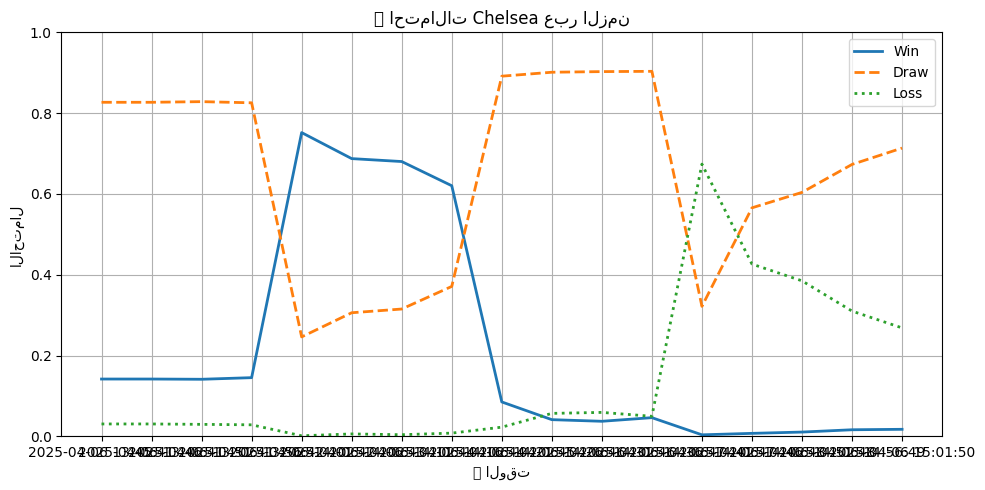

In [35]:
import matplotlib.pyplot as plt

for team in df_curve['team'].unique():
    team_data = df_curve[df_curve['team'] == team]

    plt.figure(figsize=(10, 5))
    plt.plot(team_data['timestamp'], team_data['Win'], label='Win', linewidth=2)
    plt.plot(team_data['timestamp'], team_data['Draw'], linestyle='--', label='Draw', linewidth=2)
    plt.plot(team_data['timestamp'], team_data['Loss'], linestyle=':', label='Loss', linewidth=2)

    plt.title(f"📊 احتمالات {team} عبر الزمن")
    plt.xlabel("⏱️ الوقت")
    plt.ylabel("الاحتمال")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [47]:
df_raw = pd.read_csv("/content/all_data_with_rank_and_point.csv")


In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df_team = convert_to_team_level(df_all)

zero_fill_cols = [
    'team_red_cards', 'team_yellow_cards', 'team_saves',
    'opponent_red_cards', 'opponent_yellow_cards', 'opponent_saves',
    'team_offsides', 'opponent_offsides',
    'team_attempted_passes', 'opponent_attempted_passes'
]
for col in zero_fill_cols:
    df_team[col] = df_team[col].fillna(0)

for col in ['team_possession', 'opponent_possession']:
    df_team[col] = df_team[col].astype(str).str.replace('%', '', regex=False).astype(float)

df_team['team_pass_accuracy'] = (df_team['team_successful_passes'] / df_team['team_attempted_passes']).fillna(0)
df_team['opponent_pass_accuracy'] = (df_team['opponent_successful_passes'] / df_team['opponent_attempted_passes']).fillna(0)

df_team.drop(columns=['team_successful_passes', 'opponent_successful_passes'], inplace=True)

le_form_team = LabelEncoder()
le_form_opp = LabelEncoder()
df_team['team_formation'] = le_form_team.fit_transform(df_team['team_formation'])
df_team['opponent_formation'] = le_form_opp.fit_transform(df_team['opponent_formation'])

df_team['team_win'] = np.where(
    df_team['team_goals'] > df_team['opponent_goals'], 1,
    np.where(df_team['team_goals'] == df_team['opponent_goals'], 0.5, 0)
)

formation_success = df_team.groupby('team_formation')['team_win'].agg(['count', 'mean']).reset_index()

formation_success = formation_success[formation_success['count'] >= 25]

most_common_opponent = (
    df_team.groupby(['team_formation', 'opponent_formation'])
    .size()
    .reset_index(name='opponent_count')
    .sort_values(['team_formation', 'opponent_count'], ascending=[True, False])
    .drop_duplicates('team_formation')
    .set_index('team_formation')['opponent_formation']
)

formation_success['opponent_formation'] = formation_success['team_formation'].map(most_common_opponent)

valid_ids = set(le_form_team.transform(le_form_team.classes_))
formation_success = formation_success[formation_success['team_formation'].isin(valid_ids)]

formation_success['team_formation'] = formation_success['team_formation'].apply(
    lambda x: le_form_team.inverse_transform([x])[0]
)
formation_success['opponent_formation'] = formation_success['opponent_formation'].apply(
    lambda x: le_form_opp.inverse_transform([x])[0]
)

formation_success = formation_success.sort_values('mean', ascending=False).reset_index(drop=True)

print("✅ Top formations by win rate (with most frequent opponent formation):")
print(formation_success.head(10))


✅ Top formations by win rate (with most frequent opponent formation):
  team_formation  count      mean opponent_formation
0        3-2-4-1     32  0.734375            4-2-3-1
1        4-2-2-2    325  0.576923            4-2-3-1
2          4-3-3   4711  0.566759            4-2-3-1
3        4-2-3-1   8296  0.523264            4-2-3-1
4        3-4-2-1   2437  0.516208            4-2-3-1
5          4-4-2   3885  0.491892            4-2-3-1
6        3-4-1-2    884  0.482466            4-2-3-1
7          3-4-3    759  0.482213            4-2-3-1
8        4-1-3-2    191  0.476440            4-2-3-1
9        4-3-1-2    999  0.473473            4-2-3-1


In [51]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df_team = convert_to_team_level(df_all)

zero_fill_cols = [
    'team_red_cards', 'team_yellow_cards', 'team_saves',
    'opponent_red_cards', 'opponent_yellow_cards', 'opponent_saves',
    'team_offsides', 'opponent_offsides',
    'team_attempted_passes', 'opponent_attempted_passes'
]
for col in zero_fill_cols:
    df_team[col] = df_team[col].fillna(0)

for col in ['team_possession', 'opponent_possession']:
    df_team[col] = df_team[col].astype(str).str.replace('%', '', regex=False).astype(float)

df_team['team_pass_accuracy'] = (df_team['team_successful_passes'] / df_team['team_attempted_passes']).fillna(0)
df_team['opponent_pass_accuracy'] = (df_team['opponent_successful_passes'] / df_team['opponent_attempted_passes']).fillna(0)

df_team.drop(columns=['team_successful_passes', 'opponent_successful_passes'], inplace=True)

le_form_team = LabelEncoder()
le_form_opp = LabelEncoder()
df_team['team_formation'] = le_form_team.fit_transform(df_team['team_formation'])
df_team['opponent_formation'] = le_form_opp.fit_transform(df_team['opponent_formation'])

df_team['team_win'] = np.where(
    df_team['team_goals'] > df_team['opponent_goals'], 1,
    np.where(df_team['team_goals'] == df_team['opponent_goals'], 0.5, 0)
)

combo_stats = df_team.groupby(['team_formation', 'opponent_formation'])['team_win'].agg(['count', 'mean']).reset_index()

combo_stats = combo_stats[combo_stats['count'] >= 10]

combo_stats['team_formation'] = combo_stats['team_formation'].apply(lambda x: le_form_team.inverse_transform([x])[0])
combo_stats['opponent_formation'] = combo_stats['opponent_formation'].apply(lambda x: le_form_opp.inverse_transform([x])[0])

combo_stats = combo_stats.sort_values('mean', ascending=False).reset_index(drop=True)

print("📊 Formation vs Opponent Formation Performance (only combos with ≥ 10 matches):")
print(combo_stats.head(15))


📊 Formation vs Opponent Formation Performance (only combos with ≥ 10 matches):
   team_formation opponent_formation  count      mean
0         3-2-4-1            4-2-3-1     11  0.909091
1         4-3-1-2              4-5-1     10  0.900000
2         3-4-1-2              4-5-1     10  0.800000
3         3-4-2-1              5-4-1     32  0.796875
4         4-1-4-1              4-5-1     13  0.769231
5         4-4-1-1              5-4-1     15  0.766667
6           4-3-3              4-5-1     72  0.763889
7           4-3-3              5-4-1    104  0.730769
8         4-2-2-2            3-1-4-2     16  0.718750
9           4-3-3              5-3-2    148  0.716216
10        4-3-1-2              5-3-2     24  0.708333
11        3-4-2-1              5-3-2     59  0.703390
12        4-2-3-1            3-5-1-1     46  0.695652
13        4-2-3-1              5-3-2    185  0.683784
14          4-4-2              4-5-1     41  0.682927


In [57]:

# ✅ Top 1 overall formation
best_formation_row = formation_success.sort_values('mean', ascending=False).head(1).iloc[0]

print("✅ Tactical Recommendation (Best Overall Formation):")
print(f"🎯 Use formation: {best_formation_row['team_formation']}")
print(f"📈 Win Rate: {best_formation_row['mean']:.2%} (Played {int(best_formation_row['count'])} times)")
print(f"📌 Most common opponent formation faced: {best_formation_row['opponent_formation']}")
print("-" * 60)

# 📊 Top 3 formation × opponent combos
top_3_combos = combo_stats.sort_values('mean', ascending=False).head(3)

print("📊 Tactical Matchups (Top 3 Formation vs Opponent combos):")
for _, row in top_3_combos.iterrows():
    print(f"🔥 Formation {row['team_formation']} vs {row['opponent_formation']} → "
          f"{row['mean']:.2%} win rate ({int(row['count'])} matches)")


✅ Tactical Recommendation (Best Overall Formation):
🎯 Use formation: 3-2-4-1
📈 Win Rate: 73.44% (Played 32 times)
📌 Most common opponent formation faced: 4-2-3-1
------------------------------------------------------------
📊 Tactical Matchups (Top 3 Formation vs Opponent combos):
🔥 Formation 3-2-4-1 vs 4-2-3-1 → 90.91% win rate (11 matches)
🔥 Formation 4-3-1-2 vs 4-5-1 → 90.00% win rate (10 matches)
🔥 Formation 3-4-1-2 vs 4-5-1 → 80.00% win rate (10 matches)


In [96]:
import shutil

model_folder = 'AutogluonModels'

output_zip = 'Best_model.zip'

shutil.make_archive('Best_model', 'zip', model_folder)

print(f"✅ Model saved as {output_zip}")


✅ Model saved as Best_model.zip
